In [1]:
from matplotlib import pyplot
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import numpy as np
from numpy import array


In [50]:
#A = array([0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0])
A = array([0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0])
#B = A[::-1] # not sure if this is the way to do it (should it be just each sample that is reversed, or the whole sequence?)

A = A.reshape((5, 4, 1))
#B = B.reshape((5, 4, 1))
C = A[::-1]

time_steps = 4
n_features = 1

print(f'A= {A}, C={C}, B={B}')

print(A.shape)


A= [[[0]
  [0]
  [0]
  [0]]

 [[1]
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  [1]]

 [[0]
  [0]
  [0]
  [0]]], C=[[[0]
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  [1]]

 [[0]
  [0]
  [0]
  [0]]

 [[1]
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  [0]]], B=[[[0]
  [0]
  [0]
  [0]]

 [[1]
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  [1]]

 [[0]
  [0]
  [0]
  [0]]]
(5, 4, 1)


In [51]:
# could be getting stuck in a local minimum for the zeros? try different initialization. also try using functional API
#time_steps = 40
#n_features = 64 # 64*40 = 2560 output shape??

AutoEncoder = Sequential()

# Encoder
AutoEncoder.add(Dense(256, activation='tanh', input_shape=(time_steps,n_features)))
AutoEncoder.add(Dropout(0.2))
AutoEncoder.add(LSTM(128, return_sequences=True,kernel_initializer ='uniform'))
AutoEncoder.add(LSTM(128, return_sequences=True,kernel_initializer ='uniform' ))
# Decoder
AutoEncoder.add(LSTM(128, return_sequences=True,kernel_initializer ='random_normal'))
AutoEncoder.add(LSTM(128,return_sequences=True,kernel_initializer ='random_normal'))
AutoEncoder.add(Dense(256, activation= 'sigmoid'))
AutoEncoder.add(Dense(1, activation= 'sigmoid')) # they don't mention this in the article but dimensions are wrong otherwise

AutoEncoder.compile(optimizer='adam', loss='binary_crossentropy')
#AutoEncoder.compile(optimizer='adam', loss='mse')
AutoEncoder.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 4, 256)            512       
_________________________________________________________________
dropout_11 (Dropout)         (None, 4, 256)            0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 4, 128)            197120    
_________________________________________________________________
lstm_42 (LSTM)               (None, 4, 128)            131584    
_________________________________________________________________
lstm_43 (LSTM)               (None, 4, 128)            131584    
_________________________________________________________________
lstm_44 (LSTM)               (None, 4, 128)            131584    
_________________________________________________________________
dense_33 (Dense)             (None, 4, 256)          

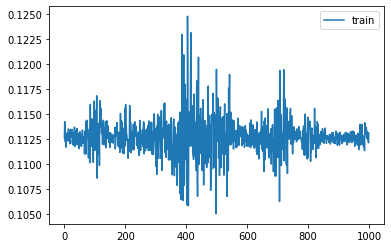

In [65]:
model = AutoEncoder
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10)

history = model.fit(A, C, epochs=1000, verbose=0, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

In [68]:
output = AutoEncoder.predict(A[3,:,:]) # why do zeros give 0.668? seems solved. sometimes get warning about input shape
print(output)

[[[2.5827253e-01]]

 [[2.5827253e-01]]

 [[2.5827253e-01]]

 [[1.6632676e-04]]]


In [63]:
print(C[3,:,:])

[[1]
 [0]
 [0]
 [0]]


In [42]:
print(A[1,:,:])

[[1]
 [0]
 [0]
 [0]]
